# Experiments

For this project the aim is to classify the emails contained in an unseen dataset as either 'spam' or 'ham'. In order to achieve that we will first experiment with various algorithms, trying to identify the best performing one. The algorithms will be evaluated on a training dataset.

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import Normalizer, normalize
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gsevr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Pre-processing & EDA

First we will load the training data and look for null values or duplicates. Next we will investigate the label balance.

In [25]:
df = pd.read_csv('train.csv')
df.head()

,email,label
0,MiniNTK 2002-08-16 __ __ _2002-08-16 _ ____...,ham
1,Tags reveal if frozen food is rottenURL: http:...,ham
2,Personal 75% OFF to hibody@csmining.org. Pfi...,spam
3,From fork-admin@xent.com Mon Sep 23 22:47:38 ...,ham
4,Re: Anolther sequence related tracebackI have ...,ham


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   7500 non-null   object
 1   label   7500 non-null   object
dtypes: object(2)
memory usage: 117.3+ KB


In [27]:
df.describe()

,email,label
count,7500,7500
unique,7364,2
top,"Re: ARRRGHHH Had GPG working, now it doesnt.If...",ham
freq,4,5792


In [28]:
df.drop_duplicates(inplace=True)

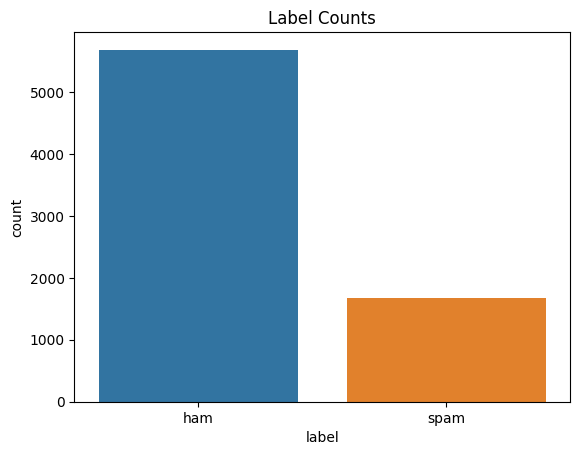

In [29]:
label_counts = df.groupby('label').count()
label_counts.columns = ['count']
sns.barplot(label_counts,x=label_counts.index,y='count')
plt.title('Label Counts')
plt.show()

Since labels are significantly unbalanced, we will undersample the 'ham' label, so that the eventual models are better fitted.

In [30]:
undersample_ham = df[df.label == 'ham'].sample(frac=0.3)
spam_df = df[df.label == 'spam']
final_df = pd.concat([undersample_ham, spam_df]).reset_index(drop=True)

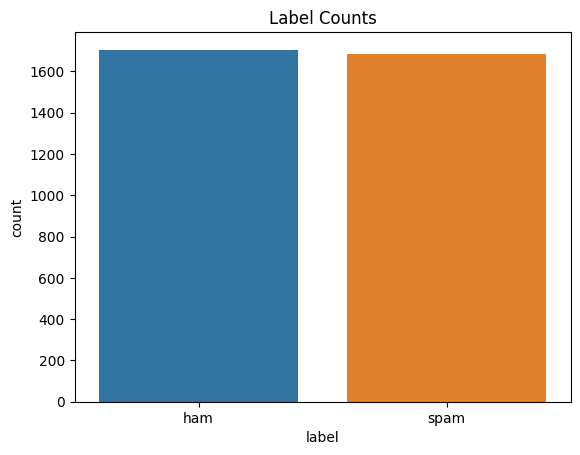

In [31]:
label_counts = final_df.groupby('label').count()
label_counts.columns = ['count']
sns.barplot(label_counts,x=label_counts.index,y='count')
plt.title('Label Counts')
plt.show()

In [32]:
df = final_df

Next, the data will be preprocessed. Special characters, numbers, stopwords, ubiquitous email words, and words with length of 3 characters or less will be removed.

In [33]:
def preprocess(text):
    text = text.lower()
    t = re.sub('\W+',r' ',text)
    t = re.sub('_',r'',t)
    t = re.sub('\d',r'',t)
    t = re.sub('\s+\S\s+',r'',t)
    t = re.sub(r'(www|com|org|list|net|mailto|subject|http)', '', t)
    t = re.sub(r'\b\w{1,3}\b', '', t)
    stopwords_list = stopwords.words('english') 
    txt = ' '.join([word for word in t.split() if word not in stopwords_list])
    return txt

lemmatizer = WordNetLemmatizer()

In [34]:
df['pre_email'] = [' '.join([lemmatizer.lemmatize(preprocess(email))])
                 .strip() for email in df['email']]

We can now see the most frequent words per label

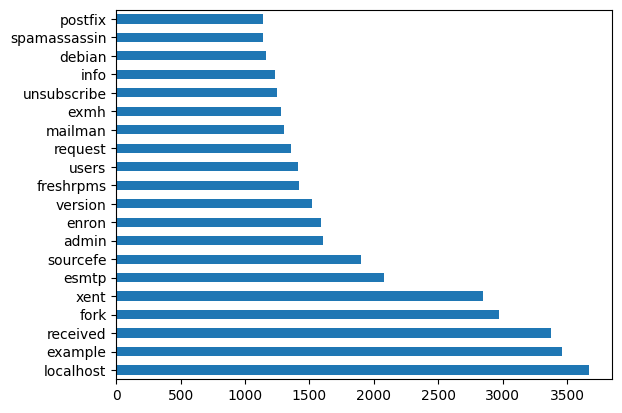

In [35]:
top_ham = pd.Series(' '.join(df['pre_email'][df.label == 'ham']).split()).value_counts()[:20]
top_ham.plot.barh()
plt.show()

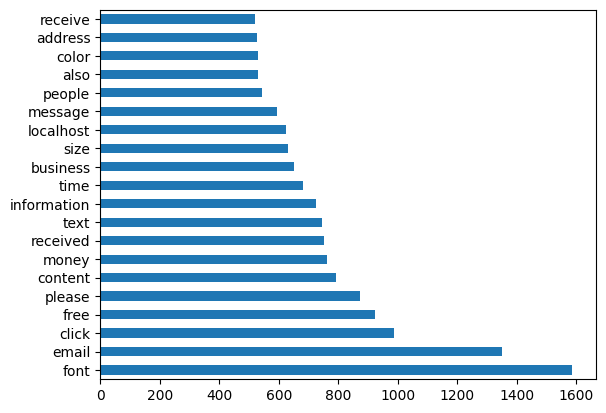

In [36]:
top_spam = pd.Series(' '.join(df['pre_email'][df.label == 'spam']).split()).value_counts()[:20] 
top_spam.plot.barh()
plt.show()

The next step will be to vectorize and then normalize the emails.

In [37]:
tfidf= TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1,2),
                       stop_words='english',norm='l2',binary=False)

tfidf.fit(df.pre_email)

X_train = tfidf.transform(df.pre_email)
y_train = df.label

In [38]:
X_train.data**=0.5
normalize(X_train,copy=False)

<3387x350113 sparse matrix of type '<class 'numpy.float64'>'
	with 781358 stored elements in Compressed Sparse Row format>

Finally, grid search will be performed for the various chosen algorithms in order to find the optimal parameters.

In [39]:
cnb = ComplementNB()

cnb_param_grid = {
    'alpha': [0.1, 0.5, 1.0], 
    'fit_prior': [True, False]  
    }

cnb_grid = GridSearchCV(cnb,
                    cnb_param_grid,
                    cv=5,
                    refit='accuracy',
                    scoring='accuracy')

cnb_grid.fit(X_train, df.label)

print(f'Best parameters found are: {cnb_grid.best_params_}, with a score of {cnb_grid.best_score_}')  
pd.DataFrame.from_dict(cnb_grid.cv_results_,orient='columns')

Best parameters found are: {'alpha': 0.1, 'fit_prior': True}, with a score of 0.9734260554328266


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028208,0.000980,0.005201,0.000401,0.1,True,"{'alpha': 0.1, 'fit_prior': True}",0.971976,0.980826,0.980798,0.968981,0.964549,0.973426,0.006477,1
1,0.029629,0.004215,0.005586,0.000478,0.1,False,"{'alpha': 0.1, 'fit_prior': False}",0.971976,0.980826,0.980798,0.968981,0.964549,0.973426,0.006477,1
2,0.032004,0.005255,0.004996,0.000012,0.5,True,"{'alpha': 0.5, 'fit_prior': True}",0.967552,0.971976,0.970458,0.957164,0.964549,0.966340,0.005246,3
3,0.027409,0.000487,0.005205,0.000411,0.5,False,"{'alpha': 0.5, 'fit_prior': False}",0.967552,0.971976,0.970458,0.957164,0.964549,0.966340,0.005246,3
4,0.027723,0.000732,0.005483,0.000444,1.0,True,"{'alpha': 1.0, 'fit_prior': True}",0.958702,0.966077,0.964549,0.954210,0.955687,0.959845,0.004718,5
5,0.029737,0.003291,0.006000,0.000895,1.0,False,"{'alpha': 1.0, 'fit_prior': False}",0.958702,0.966077,0.964549,0.954210,0.955687,0.959845,0.004718,5


In [40]:
#kNN

knn = KNeighborsClassifier()

knn_param_grid = {'n_neighbors': [3, 5, 9],  
                  'weights': ['uniform', 'distance'],  
                  'p': [1, 2]
                 }
                    
knn_grid = GridSearchCV(knn,
                    knn_param_grid,
                    cv=5,
                    refit='accuracy',
                    scoring='accuracy')

knn_grid.fit(X_train, df.label)

print(f'Best parameters found are: {knn_grid.best_params_}, with a score of {knn_grid.best_score_}')  
pd.DataFrame.from_dict(knn_grid.cv_results_,orient='columns')

Best parameters found are: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}, with a score of 0.9518764460595286


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011202,0.002135,0.208630,0.033253,3,1,uniform,"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.497050,0.497050,0.496307,0.496307,0.496307,0.496604,0.000364,10
1,0.011801,0.000400,0.171232,0.017785,3,1,distance,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",0.498525,0.497050,0.497784,0.496307,0.496307,0.497195,0.000862,7
2,0.011602,0.001200,7.026988,0.205620,3,2,uniform,"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.557522,0.576696,0.579025,0.570162,0.583456,0.573372,0.009014,6
3,0.012003,0.000895,7.896271,0.456136,3,2,distance,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.561947,0.582596,0.589365,0.577548,0.593796,0.581050,0.011056,5
4,0.012402,0.000491,0.217432,0.009136,5,1,uniform,"{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}",0.497050,0.497050,0.496307,0.496307,0.496307,0.496604,0.000364,10
5,0.012201,0.000400,0.204031,0.016878,5,1,distance,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.498525,0.497050,0.497784,0.496307,0.496307,0.497195,0.000862,7
6,0.012201,0.000400,8.101449,0.274633,5,2,uniform,"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.957227,0.560472,0.951256,0.940916,0.561300,0.794234,0.190600,4
7,0.011401,0.001356,8.238725,0.407208,5,2,distance,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.958702,0.567847,0.952733,0.940916,0.574594,0.798958,0.186048,3
8,0.011002,0.000895,0.225661,0.019529,9,1,uniform,"{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}",0.497050,0.497050,0.496307,0.496307,0.496307,0.496604,0.000364,10
9,0.011801,0.000400,0.222826,0.019365,9,1,distance,"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",0.498525,0.497050,0.497784,0.496307,0.496307,0.497195,0.000862,7


In [41]:
svc = SVC()

svc_param_grid = {'C': [0.1, 1, 10],
                  'kernel': ['linear', 'rbf', 'poly']
                 }

svc_grid = GridSearchCV(svc,
                    svc_param_grid,
                    cv=5,
                    refit='accuracy',
                    scoring='accuracy')

svc_grid.fit(X_train, df.label)

print(f'Best parameters found are: {svc_grid.best_params_}, with a score of {svc_grid.best_score_}')  
pd.DataFrame.from_dict(svc_grid.cv_results_,orient='columns')

Best parameters found are: {'C': 1, 'kernel': 'linear'}, with a score of 0.9781532267552059


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.964521,0.223757,1.452869,0.055318,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.851032,0.824484,0.838996,0.822747,0.836041,0.834660,0.010337,5
1,6.875525,0.083823,1.758402,0.030866,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.668142,0.668142,0.683900,0.645495,0.672083,0.667552,0.012450,9
2,6.989909,0.087458,1.781740,0.028793,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.706490,0.728614,0.689808,0.630724,0.688331,0.688793,0.032472,8
3,5.931321,0.098565,1.063296,0.024456,1,linear,"{'C': 1, 'kernel': 'linear'}",0.976401,0.974926,0.985229,0.970458,0.983752,0.978153,0.005552,1
4,6.971410,0.068806,1.529495,0.041078,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.967552,0.971976,0.966027,0.966027,0.966027,0.967522,0.002304,4
5,7.105992,0.116058,1.721153,0.015943,1,poly,"{'C': 1, 'kernel': 'poly'}",0.825959,0.800885,0.871492,0.803545,0.818316,0.824039,0.025473,6
6,5.943000,0.132396,1.081635,0.013680,10,linear,"{'C': 10, 'kernel': 'linear'}",0.979351,0.967552,0.983752,0.974889,0.980798,0.977268,0.005637,2
7,7.289441,0.494616,1.524066,0.051233,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.970501,0.974926,0.970458,0.967504,0.973412,0.971360,0.002583,3
8,7.159302,0.071524,1.741267,0.041385,10,poly,"{'C': 10, 'kernel': 'poly'}",0.812684,0.780236,0.840473,0.797637,0.797637,0.805733,0.020181,7


In [42]:
rf = RandomForestClassifier()

rf_param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini','entropy'],
                'max_depth':[5,7,10],
                'oob_score':[True, False]
                }

rf_grid = GridSearchCV(rf,
                    rf_param_grid,
                    cv=5,
                    refit='accuracy',
                    scoring='accuracy')

rf_grid.fit(X_train, df.label)

print(f'Best parameters found are: {rf_grid.best_params_}, with a score of {rf_grid.best_score_}')  
pd.DataFrame.from_dict(rf_grid.cv_results_,orient='columns')

Best parameters found are: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100, 'oob_score': False}, with a score of 0.8033646618998445


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,param_oob_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.814925,0.024187,0.097428,0.003555,gini,5,50,True,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.802360,0.743363,0.768095,0.745938,0.745938,0.761139,0.022475,25
1,0.657607,0.010845,0.097603,0.004149,gini,5,50,False,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.753687,0.734513,0.797637,0.711965,0.774003,0.754361,0.029834,28
2,1.599997,0.060845,0.198679,0.011380,gini,5,100,True,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.787611,0.756637,0.769572,0.729690,0.719350,0.752572,0.025142,29
3,1.276720,0.036957,0.185198,0.005058,gini,5,100,False,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.749263,0.733038,0.759232,0.731167,0.741507,0.742841,0.010431,33
4,3.209804,0.031142,0.406370,0.044025,gini,5,200,True,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.740413,0.730088,0.771049,0.728213,0.734121,0.740777,0.015703,36
5,2.603445,0.016658,0.383835,0.019654,gini,5,200,False,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.750737,0.740413,0.771049,0.734121,0.734121,0.746088,0.013880,30
6,1.063970,0.023394,0.102862,0.008508,gini,7,50,True,"{'criterion': 'gini', 'max_depth': 7, 'n_estim...",0.792035,0.771386,0.762186,0.754801,0.734121,0.762906,0.019054,22
7,0.947044,0.068325,0.105138,0.006906,gini,7,50,False,"{'criterion': 'gini', 'max_depth': 7, 'n_estim...",0.800885,0.758112,0.800591,0.809453,0.748892,0.783587,0.024940,13
8,2.167039,0.042316,0.191608,0.005313,gini,7,100,True,"{'criterion': 'gini', 'max_depth': 7, 'n_estim...",0.752212,0.769912,0.807976,0.756278,0.753323,0.767940,0.020994,16
9,1.831746,0.037626,0.192112,0.005376,gini,7,100,False,"{'criterion': 'gini', 'max_depth': 7, 'n_estim...",0.769912,0.765487,0.793205,0.763663,0.756278,0.769709,0.012545,15


In [43]:
sgd = SGDClassifier()

sgd_param_grid = {'loss': ['log_loss', 'perceptron'],
                  'penalty': ['l1','l2','elasticnet'],
                  'alpha': [0.0001, 0.0003, 0.0009, 0.001, 0.003, 0.009],
                  'max_iter': [1000, 3000, 9000]
                 }

sgd_grid = GridSearchCV(sgd,
                sgd_param_grid,
                cv=5,
                refit='accuracy',
                scoring='accuracy')

sgd_grid.fit(X_train, df.label)

print(f'Best parameters found are: {sgd_grid.best_params_}, with a score of {sgd_grid.best_score_}')
pd.DataFrame.from_dict(sgd_grid.cv_results_,orient='columns')

Best parameters found are: {'alpha': 0.003, 'loss': 'perceptron', 'max_iter': 3000, 'penalty': 'l2'}, with a score of 0.9760844084826777


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_loss,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.100458,0.004343,0.001602,0.000500,0.0001,log_loss,1000,l1,"{'alpha': 0.0001, 'loss': 'log_loss', 'max_ite...",0.955752,0.961652,0.958641,0.961595,0.957164,0.958961,0.002358,28
1,0.021602,0.000489,0.001411,0.000490,0.0001,log_loss,1000,l2,"{'alpha': 0.0001, 'loss': 'log_loss', 'max_ite...",0.966077,0.973451,0.967504,0.968981,0.967504,0.968703,0.002546,20
2,0.059997,0.000881,0.001801,0.000399,0.0001,log_loss,1000,elasticnet,"{'alpha': 0.0001, 'loss': 'log_loss', 'max_ite...",0.963127,0.969027,0.963072,0.968981,0.966027,0.966047,0.002640,23
3,0.100776,0.001681,0.001404,0.000498,0.0001,log_loss,3000,l1,"{'alpha': 0.0001, 'loss': 'log_loss', 'max_ite...",0.955752,0.961652,0.961595,0.960118,0.958641,0.959552,0.002199,26
4,0.021598,0.000486,0.001610,0.000488,0.0001,log_loss,3000,l2,"{'alpha': 0.0001, 'loss': 'log_loss', 'max_ite...",0.966077,0.973451,0.966027,0.968981,0.968981,0.968703,0.002712,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.014802,0.000749,0.001201,0.000400,0.009,perceptron,3000,l2,"{'alpha': 0.009, 'loss': 'perceptron', 'max_it...",0.973451,0.971976,0.973412,0.968981,0.977843,0.973133,0.002862,13
104,0.031404,0.001021,0.001802,0.000401,0.009,perceptron,3000,elasticnet,"{'alpha': 0.009, 'loss': 'perceptron', 'max_it...",0.774336,0.772861,0.571640,0.559823,0.657312,0.667194,0.093169,99
105,0.045804,0.007469,0.001800,0.000400,0.009,perceptron,9000,l1,"{'alpha': 0.009, 'loss': 'perceptron', 'max_it...",0.497050,0.497050,0.503693,0.496307,0.496307,0.498082,0.002825,108
106,0.015797,0.000752,0.001809,0.000405,0.009,perceptron,9000,l2,"{'alpha': 0.009, 'loss': 'perceptron', 'max_it...",0.970501,0.980826,0.976366,0.960118,0.982275,0.974017,0.008070,9


Finally, we can plot the algorithms performance, both overall and per fold.

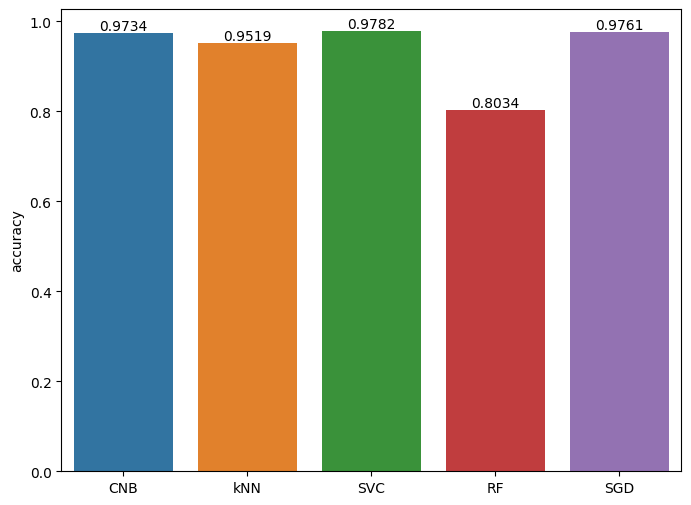

In [45]:
scores = {'CNB': cnb_grid.best_score_,
         'kNN': knn_grid.best_score_,
         'SVC': svc_grid.best_score_,
         'RF': rf_grid.best_score_,
         'SGD': sgd_grid.best_score_}


scores_df = pd.DataFrame.from_dict(scores, columns=['accuracy'], orient='index')

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=scores_df,x=scores_df.index,y='accuracy')
ax.bar_label(ax.containers[0], fmt='%.4f')
plt.show()

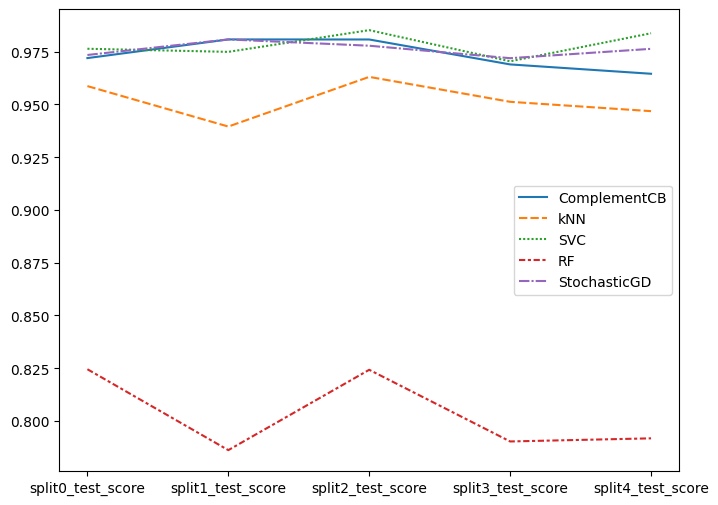

In [139]:
test_scores = ['split0_test_score',
               'split1_test_score',
               'split2_test_score',
               'split3_test_score',
               'split4_test_score']

names = ['ComplementCB','kNN','SVC','RF','StochasticGD']

cnb_df = pd.DataFrame.from_dict(cnb_grid.cv_results_,orient='columns')
knn_df = pd.DataFrame.from_dict(knn_grid.cv_results_,orient='columns')
svc_df = pd.DataFrame.from_dict(svc_grid.cv_results_,orient='columns')
rf_df = pd.DataFrame.from_dict(rf_grid.cv_results_,orient='columns')
sgd_df = pd.DataFrame.from_dict(sgd_grid.cv_results_,orient='columns')

cv_df = pd.concat([cnb_df[cnb_df.rank_test_score == 1][test_scores],
                   knn_df[knn_df.rank_test_score == 1][test_scores],
                   svc_df[svc_df.rank_test_score == 1][test_scores],
                   rf_df[rf_df.rank_test_score == 1][test_scores],
                   sgd_df[sgd_df.rank_test_score == 1][test_scores]],axis=0)

cv_df = cv_df.drop_duplicates()
cv_df = cv_df.reset_index(drop=True)
cv_df.insert(0,'Classifier',names)
cv_df = cv_df.T
cv_df.columns = names
cv_df = cv_df.drop(index='Classifier')
cv_df.index = test_scores

plt.figure(figsize=(8,6))
sns.lineplot(cv_df)
plt.show()